In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# lecture de la base de données
df = pd.read_csv("https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins.csv")
df = df.dropna() # pour supprimer les lignes avec des valeurs manquantes
# print(df.head()) # pour afficher les premières lignes

# matrice des entrées (longueur du bec, largueur du bec, longueur des nageoires, poids du corps)
entrees = df[["bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g"]].to_numpy()

# matrice des sorties (manchot Adélie, manchot Papou, manchot à jugulaire)
sp = ["Adelie","Gentoo","Chinstrap"]
sorties = np.zeros([len(df),len(sp)])
for s in range(len(sp)) :
   sorties[:,s] = df.species==sp[s]

In [14]:
# Normalisation (important : évite dominances d'échelle)
mu = entrees.mean(axis=0) # moyenne par colonne
sigma = entrees.std(axis=0) # écart-type par colonne
entrees = (entrees - mu) / sigma # standardisation donc on garde shape (N,d) et on modifie les valeurs pour centrer/réduire les données

# fonction pour diviser les données en un ensemble d'entrainement et un ensemble de test
def donnees_entrainement_test(entrees, sorties, proportion_test):
    nb_exemples = entrees.shape[0]
    nb_test = int(nb_exemples * proportion_test)
    indices = np.random.permutation(nb_exemples)
    test_idx, train_idx = indices[:nb_test], indices[nb_test:]
    return entrees[train_idx,:], sorties[train_idx,:], entrees[test_idx,:], sorties[test_idx,:]

perm = np.loadtxt("randperm0_332.txt", dtype=float).astype(int)

# Réordonnancement selon la permutation
entrees_perm = entrees[perm, :]
sorties_perm = sorties[perm, :]

def separe_tab(entrees, sorties, proportion_valid, proportion_test):
    nb_exemples = entrees.shape[0]
    nb_valid = int(nb_exemples * proportion_valid)
    nb_test = int(nb_exemples * proportion_test)
    nb_train = nb_exemples - nb_valid - nb_test

    X_train = entrees[:nb_train, :]
    Y_train = sorties[:nb_train, :]
    X_valid = entrees[nb_train:nb_train + nb_valid, :]
    Y_valid = sorties[nb_train:nb_train + nb_valid, :]
    X_test = entrees[nb_train + nb_valid:, :]
    Y_test = sorties[nb_train + nb_valid:, :]

    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test

'''
Définition

Epoch :
Dans le contexte de l'entraînement d'un modèle, l'"epoch" est un terme utilisé 
pour référer à une itération où le modèle voit tout le training set pour mettre à jour ses coefficients.
'''

def widrow_hoff(entrees, sorties, taux_apprentissage=0.01, epochs=10):
    ligne = entrees.shape[0]
    nb_attributs = entrees.shape[1]
    sortie_reelle = sorties.shape[1]

    # initialisation stable des poids / biais
    facteur_normalisation = 1 / np.sqrt(nb_attributs)
    matrice_poids = np.random.randn(nb_attributs, sortie_reelle) * facteur_normalisation
    vecteur_biais = np.zeros((1, sortie_reelle))

    tab_erreur_moyenne = []

    for epoch in range(epochs):
        # On mélange les exemples pour chaque itérations
        perm = np.random.permutation(ligne)
        somme = 0.0

        # Donc on parcourt les exemples dans un ordre aléatoire, puis pour j chaque sortie on calcule la sortie du perceptron Sj
        # on calcule l'erreur entre la sortie attendue SA et la sortie réelle Sj, puis on met à jour les poids et biais en conséquence
        # somme est la somme des erreurs quadratiques pour cette itération, 
        # on calcule l'erreur moyenne à la fin de l'itération et on l'ajoute à tab_erreur_moyenne
        for exemple in perm:
            entrees_utilisees = entrees[exemple, :]
            SA = sorties[exemple, :]
            for j in range(sortie_reelle):
                Sj = np.dot(entrees_utilisees, matrice_poids[:, j]) + vecteur_biais[0, j]
                erreur = SA[j] - Sj
                vecteur_biais[0, j] += taux_apprentissage * erreur
                for i in range(nb_attributs):
                    matrice_poids[i, j] += taux_apprentissage * erreur * entrees_utilisees[i]
                somme += erreur**2
        erreur_moyenne = somme / (nb_attributs * sortie_reelle) 
        tab_erreur_moyenne.append(erreur_moyenne)

    return matrice_poids, vecteur_biais, tab_erreur_moyenne


donnees_entrainement, sorties_entrainement, donnees_test, sorties_test = donnees_entrainement_test(entrees, sorties, 0.4)
matrice_poids, vecteur_biais, tab_erreur_moyenne = widrow_hoff(donnees_entrainement, sorties_entrainement, 0.008, 100)
matrice_poids_test, vecteur_biais_test, tab_erreur_moyenne_test = widrow_hoff(donnees_test, sorties_test, 0.008, 100)

""" 
plt.plot(tab_erreur_moyenne, label="erreur moyenne TRAIN")
plt.plot(tab_erreur_moyenne_test, label="erreur moyenne TEST")
plt.xlabel("Itérations (epochs)")
plt.ylabel("Erreur moyenne")
plt.title("Erreur donnees de test et entrainement")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

plt.plot(vecteur_biais[0, :], marker='o')
plt.xlabel("Index des biais (classe)")
plt.ylabel("Valeurs des biais")
plt.title("Valeurs des biais après entraînement")
plt.xticks(range(len(sp)), sp, rotation=30)
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

plt.plot(matrice_poids[:, 0], label=f"Poids -> {sp[0]}")
plt.plot(matrice_poids[:, 1], label=f"Poids -> {sp[1]}")
plt.plot(matrice_poids[:, 2], label=f"Poids -> {sp[2]}")
plt.legend()
plt.xlabel("Index des poids (attributs)")
plt.ylabel("Valeurs des poids")
plt.title("Valeurs des poids après entraînement")
plt.xticks(range(matrice_poids.shape[0]), ["bill_len","bill_dep","flipper_len","body_mass"])
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()
"""

' \nplt.plot(tab_erreur_moyenne, label="erreur moyenne TRAIN")\nplt.plot(tab_erreur_moyenne_test, label="erreur moyenne TEST")\nplt.xlabel("Itérations (epochs)")\nplt.ylabel("Erreur moyenne")\nplt.title("Erreur donnees de test et entrainement")\nplt.legend()\nplt.grid(True, linestyle=\'--\', alpha=0.5)\nplt.show()\n\nplt.plot(vecteur_biais[0, :], marker=\'o\')\nplt.xlabel("Index des biais (classe)")\nplt.ylabel("Valeurs des biais")\nplt.title("Valeurs des biais après entraînement")\nplt.xticks(range(len(sp)), sp, rotation=30)\nplt.grid(True, linestyle=\'--\', alpha=0.4)\nplt.show()\n\nplt.plot(matrice_poids[:, 0], label=f"Poids -> {sp[0]}")\nplt.plot(matrice_poids[:, 1], label=f"Poids -> {sp[1]}")\nplt.plot(matrice_poids[:, 2], label=f"Poids -> {sp[2]}")\nplt.legend()\nplt.xlabel("Index des poids (attributs)")\nplt.ylabel("Valeurs des poids")\nplt.title("Valeurs des poids après entraînement")\nplt.xticks(range(matrice_poids.shape[0]), ["bill_len","bill_dep","flipper_len","body_mass"])\

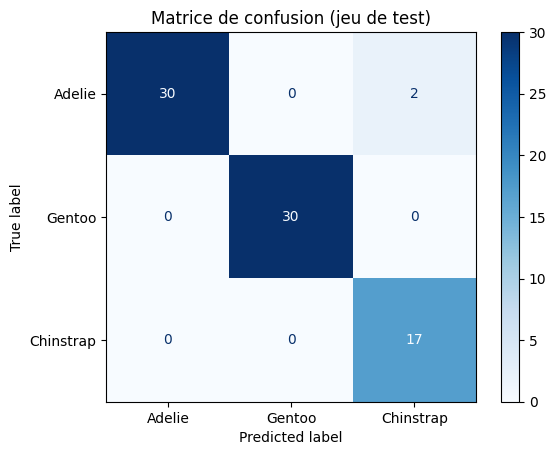

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Chargement et préparation du dataset
df = pd.read_csv("https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins.csv")
df = df.dropna()

entrees = df[["bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g"]].to_numpy()
sp = ["Adelie","Gentoo","Chinstrap"]
sorties = np.zeros([len(df), len(sp)])
for s in range(len(sp)):
    sorties[:, s] = (df.species == sp[s]).to_numpy()

# Normalisation
mu = entrees.mean(axis=0)
sigma = entrees.std(axis=0)
entrees = (entrees - mu) / sigma

# Application de la permutation connue
perm = np.loadtxt("randperm0_332.txt", dtype=float).astype(int)
entrees_perm = entrees[perm, :]
sorties_perm = sorties[perm, :]

# Séparation en 3 sous-ensembles
def separe_tab(entrees, sorties):
    X_train = entrees[:166, :]
    Y_train = sorties[:166, :]
    X_valid = entrees[166:166+88, :]
    Y_valid = sorties[166:166+88, :]
    X_test = entrees[166+88:, :]
    Y_test = sorties[166+88:, :]
    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test

X_train, Y_train, X_valid, Y_valid, X_test, Y_test = separe_tab(entrees_perm, sorties_perm)

# Algorithme de Widrow-Hoff sans biais
def widrow_hoff(entrees, sorties, taux_apprentissage=0.01, epochs=10):
    nb_exemples, nb_attributs = entrees.shape
    sortie_reelle = sorties.shape[1]
    facteur_normalisation = 1 / np.sqrt(nb_attributs)
    matrice_poids = np.random.randn(nb_attributs, sortie_reelle) * facteur_normalisation
    tab_erreur_moyenne = []

    for epoch in range(epochs):
        perm = np.random.permutation(nb_exemples)
        somme = 0.0
        for exemple in perm:
            x = entrees[exemple, :]
            y = sorties[exemple, :]
            Sj = np.dot(x, matrice_poids)
            erreur = y - Sj
            matrice_poids += taux_apprentissage * np.outer(x, erreur)
            # Aj = np.tanh(Sj)
            # erreur = y - Aj
            # matrice_poids += taux_apprentissage * np.outer(x, erreur * (1 - Aj**2))
            somme += np.sum(erreur**2)
        erreur_moyenne = somme / nb_exemples
        tab_erreur_moyenne.append(erreur_moyenne)

    return matrice_poids, tab_erreur_moyenne

# Entraînement sur le train
W, err_train = widrow_hoff(X_train, Y_train, 0.008, 100)

# Validation et test
# Y_pred_test = X_test @ W
Y_valid = np.tanh(X_valid @ W)


Y_pred_test = X_test @ W
pred_classes = np.argmax(Y_pred_test, axis=1)
true_classes = np.argmax(Y_test, axis=1)

# Matrice de confusion
cm = confusion_matrix(true_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sp)
disp.plot(cmap="Blues", values_format='d')
plt.title("Matrice de confusion (jeu de test)")
plt.show()


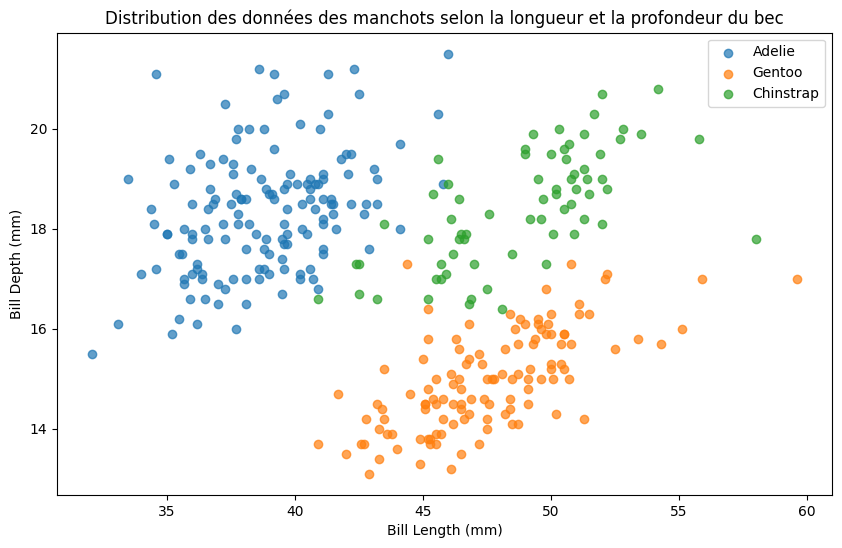

In [16]:
# Diagramme de la distribution de toutes les données 
plt.figure(figsize=(10, 6))
for i, specie in enumerate(sp):
    subset = df[df['species'] == specie]
    plt.scatter(subset['bill_length_mm'], subset['bill_depth_mm'], label=specie, alpha=0.7)
plt.xlabel("Bill Length (mm)")
plt.ylabel("Bill Depth (mm)")
plt.title("Distribution des données des manchots selon la longueur et la profondeur du bec")
plt.legend()
plt.show()




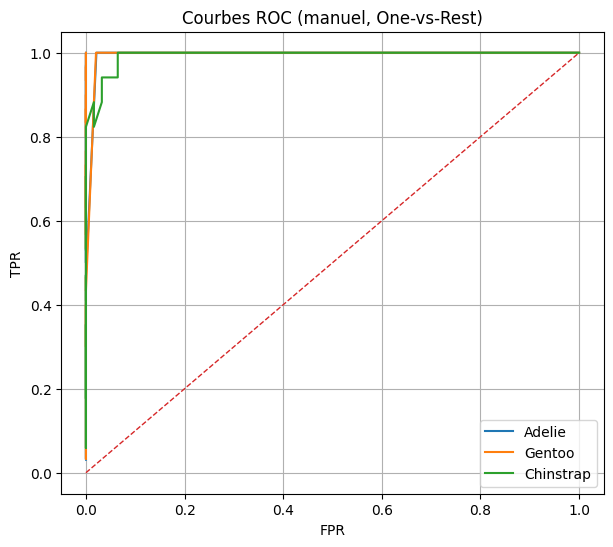

In [17]:
def compute_roc(scores, true_labels):
    # scores: (n,) score pour UNE classe (sortie tanh)
    # true_labels: (n,) booléen 0/1
    thresholds = np.sort(np.unique(scores))
    tprs, fprs = [], []

    P = np.sum(true_labels == 1)
    N = np.sum(true_labels == 0)

    for t in thresholds:
        pred = (scores >= t).astype(int)
        TP = np.sum((pred == 1) & (true_labels == 1))
        FP = np.sum((pred == 1) & (true_labels == 0))
        TPR = TP / P
        FPR = FP / N
        tprs.append(TPR)
        fprs.append(FPR)

    return np.array(fprs), np.array(tprs), thresholds

plt.figure(figsize=(7,6))

for i, specie in enumerate(sp):
    scores = Y_pred_test[:, i]
    true_bin = (true_classes == i).astype(int)
    fpr, tpr, thr = compute_roc(scores, true_bin)

    # Tri pour assurer un tracé correct
    idx = np.argsort(fpr)
    fpr, tpr = fpr[idx], tpr[idx]

    plt.plot(fpr, tpr, label=specie)

plt.plot([0,1], [0,1], '--', linewidth=1)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Courbes ROC (manuel, One-vs-Rest)")
plt.legend()
plt.grid(True)
plt.show()


AUC VALID : [np.float64(0.9877136752136753), np.float64(0.9977678571428572), np.float64(0.9849264705882352)]
AUC TEST  : [np.float64(0.9943484042553192), np.float64(0.9942176870748299), np.float64(0.993358633776091)]
MAUC VALID = 0.9901360009815893
MAUC TEST  = 0.9939749083687467
AP VALID : [np.float64(0.9624987145546355), np.float64(0.9588068181818181), np.float64(0.8960403305701293)]
AP TEST  : [np.float64(0.9594541139240507), np.float64(0.9579365079365079), np.float64(0.9019156708090874)]
MAP VALID = 0.939115287768861
MAP TEST  = 0.9397687642232153


C:\Users\phand\AppData\Local\Temp\ipykernel_5240\1208203364.py:93: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(TPR[idx], FPR[idx])
C:\Users\phand\AppData\Local\Temp\ipykernel_5240\1208203364.py:139: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(precisions[idx], recalls[idx])


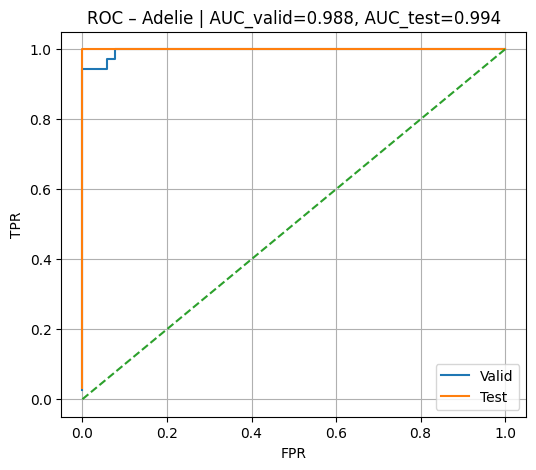

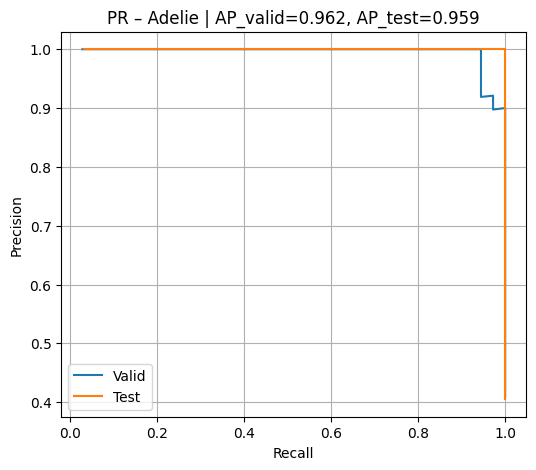

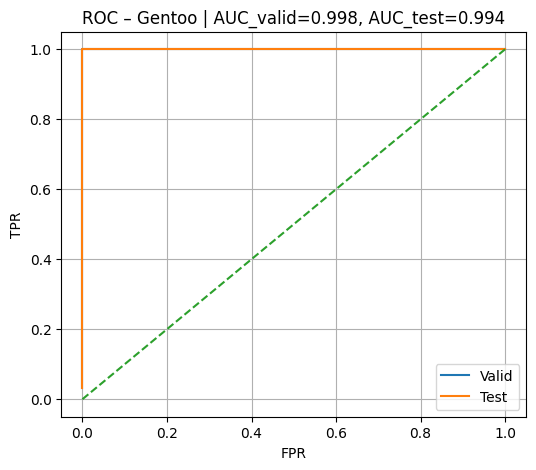

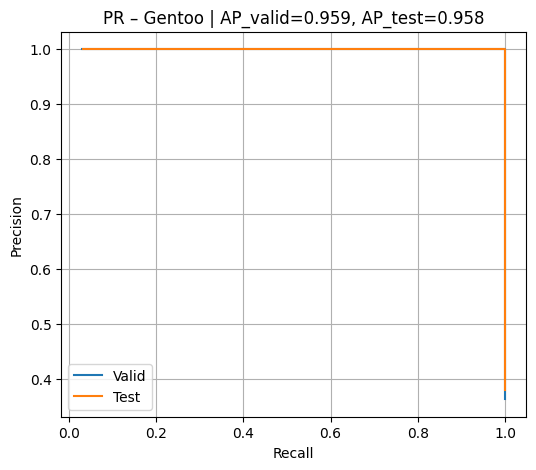

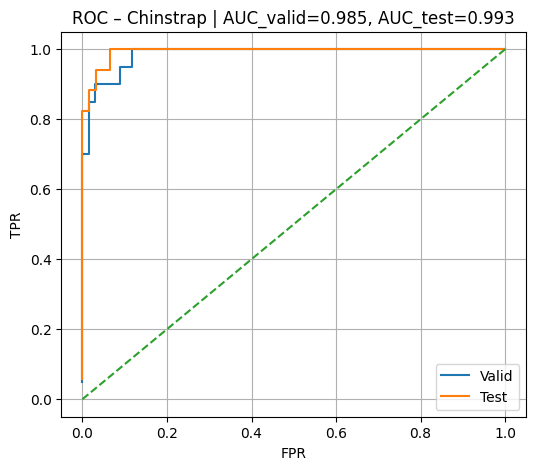

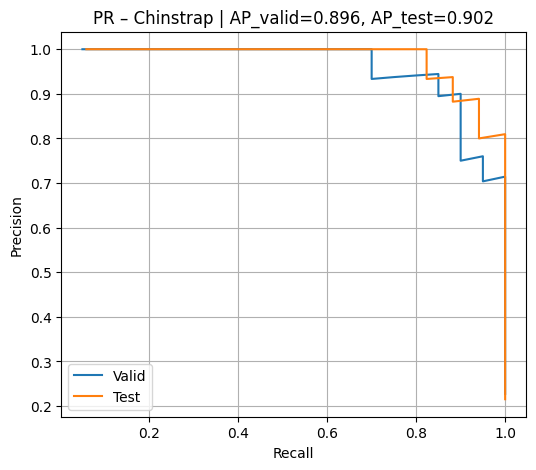

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. Chargement + nettoyage
# ---------------------------------------------------------
df = pd.read_csv(
    "https://raw.githubusercontent.com/allisonhorst/palmerpenguins/"
    "c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins.csv"
)
df = df.dropna()

sp = ["Adelie", "Gentoo", "Chinstrap"]

# Entrées
X = df[["bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g"]].to_numpy()

# Sorties one-hot
Y = np.zeros((len(df), 3))
for i, specie in enumerate(sp):
    Y[:, i] = (df.species == specie)

# Normalisation
mu = X.mean(axis=0)
sigma = X.std(axis=0)
X = (X - mu) / sigma

# ---------------------------------------------------------
# 2. Permutation fixe + split train/valid/test
# ---------------------------------------------------------
perm = np.loadtxt("randperm0_332.txt", dtype=float).astype(int)
X = X[perm, :]
Y = Y[perm, :]

def split(X, Y):
    # 166 train, 88 valid, reste test
    X_train, Y_train = X[:166], Y[:166]
    X_valid, Y_valid = X[166:166+88], Y[166:166+88]
    X_test,  Y_test  = X[166+88:], Y[166+88:]
    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test

X_train, Y_train, X_valid, Y_valid, X_test, Y_test = split(X, Y)

# ---------------------------------------------------------
# 3. Perceptron monocouche (Widrow-Hoff)
# ---------------------------------------------------------
def widrow_hoff(X, Y, lr=0.008, epochs=100):
    n, d = X.shape
    c = Y.shape[1]
    W = np.random.randn(d, c) / np.sqrt(d)
    errors = []

    for e in range(epochs):
        perm = np.random.permutation(n)
        s = 0.0
        for idx in perm:
            x = X[idx]
            y = Y[idx]
            Sj = x @ W
            err = y - Sj
            W += lr * np.outer(x, err)
            s += np.sum(err**2)
        errors.append(s / n)
    return W, errors

W, loss_train = widrow_hoff(X_train, Y_train)

# Scores sans activation pour ROC/AUC
scores_valid = X_valid @ W
scores_test  = X_test @ W

# ---------------------------------------------------------
# 4. ROC + AUC manuel One-vs-Rest
# ---------------------------------------------------------
def compute_roc(scores, true_labels):
    thresholds = np.sort(np.unique(scores))
    TPR, FPR = [], []

    P = np.sum(true_labels == 1)
    N = np.sum(true_labels == 0)

    for t in thresholds:
        pred = (scores >= t).astype(int)
        TP = np.sum((pred == 1) & (true_labels == 1))
        FP = np.sum((pred == 1) & (true_labels == 0))
        TPR.append(TP / P)
        FPR.append(FP / N)
    return np.array(FPR), np.array(TPR)

def auc(FPR, TPR):
    idx = np.argsort(FPR)
    return np.trapz(TPR[idx], FPR[idx])

AUC_valid = []
AUC_test  = []

for i in range(3):
    true_valid = (np.argmax(Y_valid, axis=1) == i).astype(int)
    true_test  = (np.argmax(Y_test,  axis=1) == i).astype(int)

    fpr_v, tpr_v = compute_roc(scores_valid[:, i], true_valid)
    fpr_t, tpr_t = compute_roc(scores_test[:,  i], true_test)

    AUC_valid.append(auc(fpr_v, tpr_v))
    AUC_test.append(auc(fpr_t, tpr_t))

# Moyennes
MAUC_valid = np.mean(AUC_valid)
MAUC_test  = np.mean(AUC_test)

print("AUC VALID :", AUC_valid)
print("AUC TEST  :", AUC_test)
print("MAUC VALID =", MAUC_valid)
print("MAUC TEST  =", MAUC_test)

# ---------------------------------------------------------
# 5. PR + Average Precision
# ---------------------------------------------------------
def compute_pr(scores, true_labels):
    thresholds = np.sort(np.unique(scores))
    precisions, recalls = [], []

    P = np.sum(true_labels == 1)

    for t in thresholds:
        pred = (scores >= t).astype(int)
        TP = np.sum((pred == 1) & (true_labels == 1))
        FP = np.sum((pred == 1) & (true_labels == 0))
        prec = TP / (TP + FP) if (TP + FP) > 0 else 1.0
        rec = TP / P
        precisions.append(prec)
        recalls.append(rec)

    return np.array(recalls), np.array(precisions)

def average_precision(recalls, precisions):
    idx = np.argsort(recalls)
    return np.trapz(precisions[idx], recalls[idx])

AP_valid = []
AP_test  = []

for i in range(3):
    true_valid = (np.argmax(Y_valid, axis=1) == i).astype(int)
    true_test  = (np.argmax(Y_test,  axis=1) == i).astype(int)

    rec_v, prec_v = compute_pr(scores_valid[:, i], true_valid)
    rec_t, prec_t = compute_pr(scores_test[:,  i], true_test)

    AP_valid.append(average_precision(rec_v, prec_v))
    AP_test.append(average_precision(rec_t, prec_t))

MAP_valid = np.mean(AP_valid)
MAP_test  = np.mean(AP_test)

print("AP VALID :", AP_valid)
print("AP TEST  :", AP_test)
print("MAP VALID =", MAP_valid)
print("MAP TEST  =", MAP_test)

# ---------------------------------------------------------
# 6. TRAÇAGE ROC et PR
# ---------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np

# 3 classes
classes = ["Adelie", "Gentoo", "Chinstrap"]

for i in range(3):

    # ------------------------------
    # 1) ROC VALID + TEST
    # ------------------------------
    yv = (np.argmax(Y_valid, axis=1) == i).astype(int)
    yt = (np.argmax(Y_test,  axis=1) == i).astype(int)

    fpr_v, tpr_v = compute_roc(scores_valid[:, i], yv)
    fpr_t, tpr_t = compute_roc(scores_test[:,  i], yt)

    auc_v = auc(fpr_v, tpr_v)
    auc_t = auc(fpr_t, tpr_t)

    plt.figure(figsize=(6,5))
    plt.plot(fpr_v, tpr_v, label="Valid")
    plt.plot(fpr_t, tpr_t, label="Test")
    plt.plot([0,1],[0,1],'--')
    plt.title(f"ROC – {classes[i]} | AUC_valid={auc_v:.3f}, AUC_test={auc_t:.3f}")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.grid()
    plt.show()

    # ------------------------------
    # 2) PR VALID + TEST
    # ------------------------------
    rec_v, prec_v = compute_pr(scores_valid[:, i], yv)
    rec_t, prec_t = compute_pr(scores_test[:,  i], yt)

    ap_v = average_precision(rec_v, prec_v)
    ap_t = average_precision(rec_t, prec_t)

    plt.figure(figsize=(6,5))
    plt.plot(rec_v, prec_v, label="Valid")
    plt.plot(rec_t, prec_t, label="Test")
    plt.title(f"PR – {classes[i]} | AP_valid={ap_v:.3f}, AP_test={ap_t:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid()
    plt.show()



Tableau des métriques (AUC et Average Precision):
     class  auc_valid  auc_test  ap_valid  ap_test
   Adelie   1.000000  0.997305    1.0000 0.996157
   Gentoo   1.000000  1.000000    1.0000 1.000000
Chinstrap   0.996528  0.998623    0.9875 0.995958

MAUC(valid)=0.9988, MAUC(test)=0.9986
MAP(valid) =0.9958, MAP(test) =0.9974


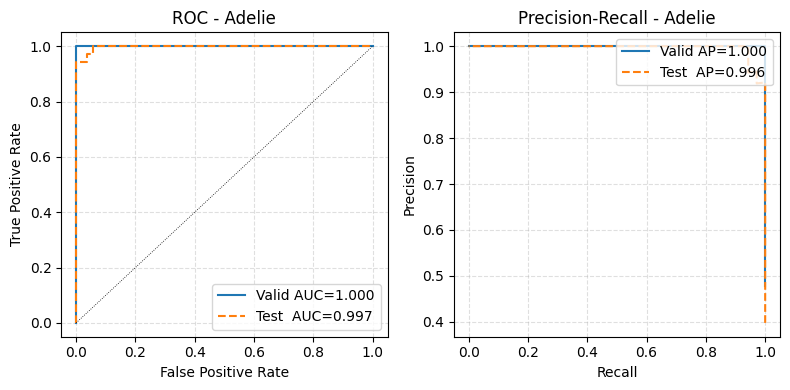

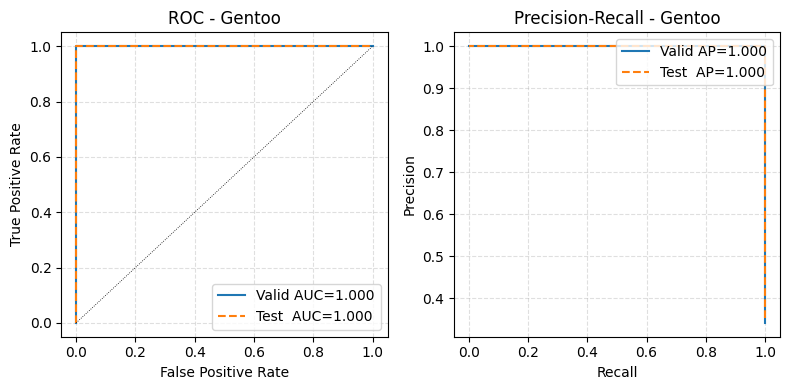

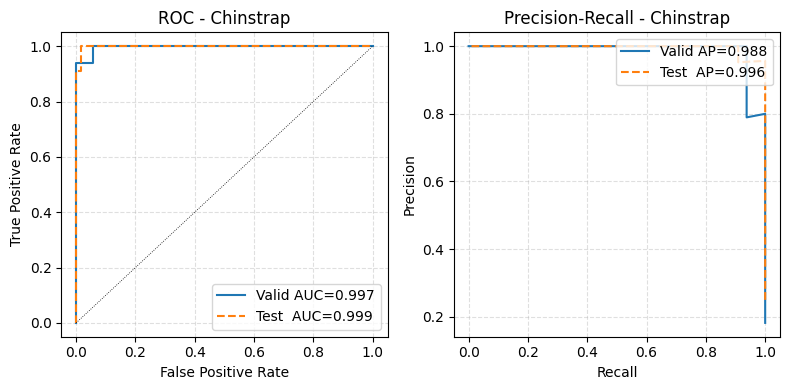

In [19]:
# analyse_manchots_widrow_hoff.py
# Usage: python3 analyse_manchots_widrow_hoff.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
)
from sklearn.utils import check_random_state

# -------------------------
# Réglages / Hypothèses
# -------------------------
RANDOM_STATE = 0
PERM_PATH = "randperm0_332.txt"   # si absent, on utilisera une permutation aléatoire
VALID_SLICE = (166, 166 + 88)     # découpage fixé par l'énoncé
np_rand = check_random_state(RANDOM_STATE)

# -------------------------
# Chargement + prétraitement
# -------------------------
df = pd.read_csv(
    "https://raw.githubusercontent.com/allisonhorst/"
    "palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins.csv"
)
df = df.dropna(subset=["bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g","species"])
X = df[["bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g"]].to_numpy(dtype=float)
species = ["Adelie", "Gentoo", "Chinstrap"]
Y = np.zeros((len(df), len(species)), dtype=int)
for i,s in enumerate(species):
    Y[:, i] = (df.species == s).to_numpy(dtype=int)

# standardisation (mu/sigma)
mu = X.mean(axis=0)
sigma = X.std(axis=0, ddof=0)
X = (X - mu) / sigma

# appliquer permutation connue si disponible sinon aléatoire (reproductible)
try:
    perm = np.loadtxt(PERM_PATH, dtype=int)
    if perm.shape[0] != X.shape[0]:
        raise ValueError("taille de permutation != nombre d'exemples, on génère une permutation propre.")
except Exception:
    perm = np_rand.permutation(X.shape[0])
X = X[perm, :]
Y = Y[perm, :]

# découpage train/valid/test (indices fournis)
train_end = VALID_SLICE[0]
valid_start, valid_end = VALID_SLICE
X_train, Y_train = X[:train_end, :], Y[:train_end, :]
X_valid, Y_valid = X[valid_start:valid_end, :], Y[valid_start:valid_end, :]
X_test,  Y_test  = X[valid_end:, :], Y[valid_end:, :]

# -------------------------
# Widrow-Hoff (vectorisé, with optional bias)
# -------------------------
def widrow_hoff(X, Y, lr=0.008, epochs=100, add_bias=True, random_state=None):
    rng = check_random_state(random_state)
    n, d = X.shape
    k = Y.shape[1]
    Xw = X.copy()
    if add_bias:
        Xw = np.hstack([Xw, np.ones((n,1))])  # bias as extra feature
        d += 1
    # Xavier-like init
    W = rng.randn(d, k) * (1.0 / np.sqrt(d))
    losses = []
    for ep in range(epochs):
        perm = rng.permutation(n)
        ssum = 0.0
        for idx in perm:
            x = Xw[idx:idx+1, :]                # shape (1,d)
            y = Y[idx:idx+1, :].astype(float)   # shape (1,k)
            Sj = x.dot(W)                       # linear outputs (1,k)
            err = y - Sj
            W += lr * x.T.dot(err)              # update weights (d,k)
            ssum += np.sum(err**2)
        losses.append(ssum / n)
    return W, losses

W, loss_train = widrow_hoff(X_train, Y_train, lr=0.008, epochs=200, add_bias=True, random_state=RANDOM_STATE)

# -------------------------
# Scores -> probabilités (sigmoid per-class)
# -------------------------
def sigmoid(z): 
    return 1.0 / (1.0 + np.exp(-z))

def scores_from_W(W, X, add_bias=True):
    Xw = X.copy()
    if add_bias:
        Xw = np.hstack([Xw, np.ones((Xw.shape[0],1))])
    S = Xw.dot(W)        # shape (n_samples, n_classes)
    P = sigmoid(S)       # treat linear outputs as logit-like scores
    return S, P

S_valid, P_valid = scores_from_W(W, X_valid, add_bias=True)
S_test,  P_test  = scores_from_W(W, X_test,  add_bias=True)

# -------------------------
# Metrics: ROC & PR (per class) + Moyennes
# -------------------------
results = []
auc_valid_list, auc_test_list = [], []
ap_valid_list, ap_test_list = [], []

for i, cls in enumerate(species):
    # ROC AUC
    auc_v = roc_auc_score(Y_valid[:,i], P_valid[:,i])
    auc_t = roc_auc_score(Y_test[:,i], P_test[:,i])
    auc_valid_list.append(auc_v); auc_test_list.append(auc_t)
    # Precision-Recall / AP
    ap_v = average_precision_score(Y_valid[:,i], P_valid[:,i])
    ap_t = average_precision_score(Y_test[:,i], P_test[:,i])
    ap_valid_list.append(ap_v); ap_test_list.append(ap_t)
    results.append({
        "class": cls,
        "auc_valid": auc_v,
        "auc_test":  auc_t,
        "ap_valid":  ap_v,
        "ap_test":   ap_t
    })

# Mean AUC (MAUC) and Mean Average Precision (MAP)
MAUC_valid = np.mean(auc_valid_list)
MAUC_test  = np.mean(auc_test_list)
MAP_valid  = np.mean(ap_valid_list)
MAP_test   = np.mean(ap_test_list)

# -------------------------
# Affichage tabulaire synthétique
# -------------------------
df_metrics = pd.DataFrame(results)
df_metrics = df_metrics[["class","auc_valid","auc_test","ap_valid","ap_test"]]
print("\nTableau des métriques (AUC et Average Precision):\n", df_metrics.to_string(index=False))
print(f"\nMAUC(valid)={MAUC_valid:.4f}, MAUC(test)={MAUC_test:.4f}")
print(f"MAP(valid) ={MAP_valid:.4f}, MAP(test) ={MAP_test:.4f}")

# -------------------------
# Tracé : un fichier / classe contenant ROC + PR (validation vs test)
# -------------------------
for i, cls in enumerate(species):
    plt.figure(figsize=(8,4))
    # ROC
    plt.subplot(1,2,1)
    fpr_v, tpr_v, _ = roc_curve(Y_valid[:,i], P_valid[:,i])
    fpr_t, tpr_t, _ = roc_curve(Y_test[:,i], P_test[:,i])
    plt.plot(fpr_v, tpr_v, label=f"Valid AUC={auc_valid_list[i]:.3f}")
    plt.plot(fpr_t, tpr_t, label=f"Test  AUC={auc_test_list[i]:.3f}", linestyle="--")
    plt.plot([0,1],[0,1], color="k", linewidth=0.6, linestyle=":")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC - {cls}")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.4)

    # Precision-Recall
    plt.subplot(1,2,2)
    prec_v, rec_v, _ = precision_recall_curve(Y_valid[:,i], P_valid[:,i])
    prec_t, rec_t, _ = precision_recall_curve(Y_test[:,i], P_test[:,i])
    plt.plot(rec_v, prec_v, label=f"Valid AP={ap_valid_list[i]:.3f}")
    plt.plot(rec_t, prec_t, label=f"Test  AP={ap_test_list[i]:.3f}", linestyle="--")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall - {cls}")
    plt.legend(loc="upper right")
    plt.grid(True, linestyle='--', alpha=0.4)

    plt.tight_layout()
    plt.savefig(f"plots_{cls.replace(' ','_')}.png", dpi=150)
    plt.show()



--- Test bruité uniquement ---
Adelie: AUC(test bruité)=0.973, AP(test bruité)=0.975
Gentoo: AUC(test bruité)=0.970, AP(test bruité)=0.945
Chinstrap: AUC(test bruité)=0.992, AP(test bruité)=0.985

--- Train bruité + Test bruité ---
Adelie: AUC(test bruité)=0.972, AP(test bruité)=0.973
Gentoo: AUC(test bruité)=0.970, AP(test bruité)=0.934
Chinstrap: AUC(test bruité)=0.987, AP(test bruité)=0.980


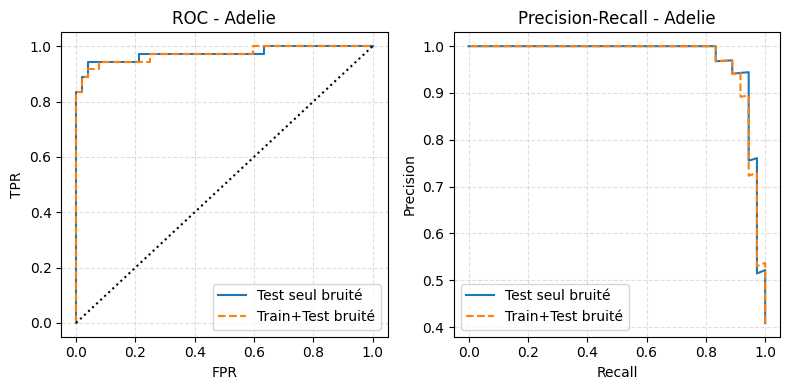

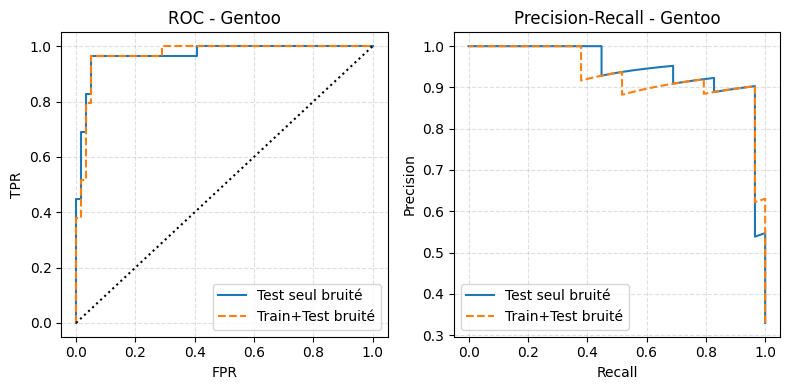

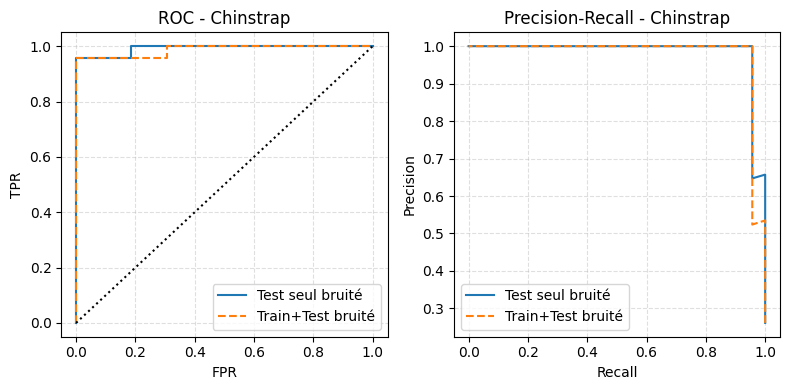

In [20]:
# -------------------------
# Ajout de bruit (signal + labels)
# -------------------------
def add_noise(X, Y, sigma_signal=0.3, flip_rate=0.1, random_state=None):
    rng = check_random_state(random_state)
    X_noisy = X + rng.normal(0, sigma_signal, X.shape)
    Y_noisy = Y.copy()
    n_samples, n_classes = Y.shape
    flip_mask = rng.rand(n_samples) < flip_rate
    for idx in np.where(flip_mask)[0]:
        # assigner une classe aléatoire différente
        Y_noisy[idx,:] = 0
        Y_noisy[idx, rng.randint(n_classes)] = 1
    return X_noisy, Y_noisy

# --- 1. Bruit uniquement sur Test ---
X_test_noise, Y_test_noise = add_noise(X_test, Y_test, sigma_signal=0.3, flip_rate=0.1, random_state=RANDOM_STATE)
S_test_noise, P_test_noise = scores_from_W(W, X_test_noise, add_bias=True)

print("\n--- Test bruité uniquement ---")
for i, cls in enumerate(species):
    auc_t = roc_auc_score(Y_test_noise[:,i], P_test_noise[:,i])
    ap_t  = average_precision_score(Y_test_noise[:,i], P_test_noise[:,i])
    print(f"{cls}: AUC(test bruité)={auc_t:.3f}, AP(test bruité)={ap_t:.3f}")

# --- 2. Bruit aussi sur Train ---
X_train_noise, Y_train_noise = add_noise(X_train, Y_train, sigma_signal=0.3, flip_rate=0.1, random_state=RANDOM_STATE)
W_noise, _ = widrow_hoff(X_train_noise, Y_train_noise, lr=0.008, epochs=200, add_bias=True, random_state=RANDOM_STATE)
S_test_noise2, P_test_noise2 = scores_from_W(W_noise, X_test_noise, add_bias=True)

print("\n--- Train bruité + Test bruité ---")
for i, cls in enumerate(species):
    auc_t = roc_auc_score(Y_test_noise[:,i], P_test_noise2[:,i])
    ap_t  = average_precision_score(Y_test_noise[:,i], P_test_noise2[:,i])
    print(f"{cls}: AUC(test bruité)={auc_t:.3f}, AP(test bruité)={ap_t:.3f}")

# Optionnel : tracé ROC/PR sur Test bruité pour comparaison
for i, cls in enumerate(species):
    plt.figure(figsize=(8,4))
    # ROC
    fpr, tpr, _ = roc_curve(Y_test_noise[:,i], P_test_noise[:,i])
    fpr2, tpr2, _ = roc_curve(Y_test_noise[:,i], P_test_noise2[:,i])
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label="Test seul bruité")
    plt.plot(fpr2, tpr2, label="Train+Test bruité", linestyle="--")
    plt.plot([0,1],[0,1], color="k", linestyle=":")
    plt.title(f"ROC - {cls}")
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.legend(); plt.grid(True, linestyle='--', alpha=0.4)

    # Precision-Recall
    prec, rec, _ = precision_recall_curve(Y_test_noise[:,i], P_test_noise[:,i])
    prec2, rec2, _ = precision_recall_curve(Y_test_noise[:,i], P_test_noise2[:,i])
    plt.subplot(1,2,2)
    plt.plot(rec, prec, label="Test seul bruité")
    plt.plot(rec2, prec2, label="Train+Test bruité", linestyle="--")
    plt.title(f"Precision-Recall - {cls}")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.legend(); plt.grid(True, linestyle='--', alpha=0.4)

    plt.tight_layout(); plt.show()
